# Explore Advanced Regression Models for Risk Prediction
This notebook trains multiple advanced regression models to predict Risk as a continuous score (0.0 to 1.0). Models include Gradient Boosting, SVR, XGBoost, LightGBM, Voting Ensemble, and more. Compare performance and select the best.

In [3]:
# Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                               AdaBoostRegressor, ExtraTreesRegressor, VotingRegressor)
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# Try to import XGBoost and LightGBM (may not be installed)
try:
    import xgboost as xgb
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("XGBoost not installed. Skipping XGBRegressor.")

try:
    import lightgbm as lgb
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False
    print("LightGBM not installed. Skipping LGBMRegressor.")

In [4]:
# Load data
import os
DATA_PATH = 'final_data.csv'
assert os.path.exists(DATA_PATH), f"{DATA_PATH} not found in notebook folder"
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())
df.head()

Shape: (242457, 6)
Columns: ['Temperature_Room', 'Humidity_Room', 'Pressure_Room', 'CO_Room', 'CO2_Room', 'Risk']


,Temperature_Room,Humidity_Room,Pressure_Room,CO_Room,CO2_Room,Risk
0,28.2,47.0,1000,0.54,926.0,0.3
1,28.2,48.1,1000,0.31,821.0,0.3
2,27.7,48.4,1000,0.10,599.0,0.3
3,27.3,47.9,1000,0.13,919.0,0.3
4,27.0,49.4,1000,0.00,737.0,0.3


In [5]:
# Preprocess features and target
features = ['Temperature_Room','Humidity_Room','Pressure_Room','CO_Room','CO2_Room']
for f in features:
    if f not in df.columns:
        raise ValueError(f"Feature {f} not found in data")

y = df['Risk'].astype(float).copy()
X = df[features].copy()

# Impute and scale
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_proc = preprocessor.fit_transform(X)
print('Preprocessed features shape:', X_proc.shape)
print('Target (Risk) statistics:')
print(y.describe())

Preprocessed features shape: (242457, 5)
Target (Risk) statistics:
count    242457.000000
mean          0.240242
std           0.366047
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max           1.000000
Name: Risk, dtype: float64


In [6]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, random_state=42)

# Create sample weights to emphasize high-risk predictions
sample_weights = 1.0 + 4.0 * y_train.values

print('Train set:', X_train.shape)
print('Test set:', X_test.shape)
print('Train target stats:')
print(pd.Series(y_train).describe())

Train set: (193965, 5)
Test set: (48492, 5)
Train target stats:
count    193965.000000
mean          0.240252
std           0.366014
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max           1.000000
Name: Risk, dtype: float64


In [7]:
# Define all models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=0.01),
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=13, min_samples_leaf=5, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=200, max_depth=10, min_samples_leaf=10, random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostRegressor(n_estimators=200, random_state=42),
    # 'SVR': SVR(kernel='rbf', C=100, gamma='scale'),
    'KernelRidge': KernelRidge(alpha=0.1, kernel='rbf', gamma=0.1),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Add XGBoost if available
if HAS_XGBOOST:
    models['XGBoost'] = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)

# Add LightGBM if available
if HAS_LGBM:
    models['LightGBM'] = lgb.LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)

# Add VotingRegressor (ensemble of best models)
voting_models = [
    ('linear', LinearRegression()),
    ('gb', GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=10, random_state=42, n_jobs=-1))
]
models['VotingEnsemble'] = VotingRegressor(estimators=voting_models, n_jobs=-1)

print(f"Training {len(models)} models...")
fitted = {}
for name, model in models.items():
    print(f"  {name}...", end='')
    try:
        model.fit(X_train, y_train, sample_weight=sample_weights)
        fitted[name] = model
        print(" ✓")
    except Exception as e:
        print(f" ✗ ({str(e)[:30]})")
        
print(f"\nSuccessfully trained {len(fitted)} models")

Training 11 models...
  LinearRegression... ✓
  Ridge... ✓
  RandomForest... ✓
  GradientBoosting... ✓
  ExtraTrees... ✓
  AdaBoost... ✓
  KernelRidge... ✗ (Unable to allocate 280. GiB fo)
  MLP... ✓
  XGBoost... ✓
  LightGBM... ✓
  VotingEnsemble... ✓

Successfully trained 10 models


In [8]:
# Evaluate all models on test set
results = {}
for name, model in fitted.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)

print('\n*** Model Comparison (sorted by R²) ***')
print(results_df.round(4))

# Highlight best
best_model = results_df.index[0]
best_r2 = results_df['R2'].iloc[0]
print(f'\n🏆 Best Model: {best_model} (R² = {best_r2:.4f})')


*** Model Comparison (sorted by R²) ***
                     MAE    RMSE      R2
MLP               0.1087  0.1807  0.7564
RandomForest      0.1066  0.1994  0.7036
XGBoost           0.1242  0.2018  0.6964
GradientBoosting  0.1256  0.2023  0.6947
LightGBM          0.1253  0.2024  0.6946
VotingEnsemble    0.1661  0.2256  0.6205
ExtraTrees        0.1814  0.2441  0.5556
LinearRegression  0.2828  0.3476  0.0987
Ridge             0.2828  0.3476  0.0987
AdaBoost          0.3244  0.3614  0.0260

🏆 Best Model: MLP (R² = 0.7564)


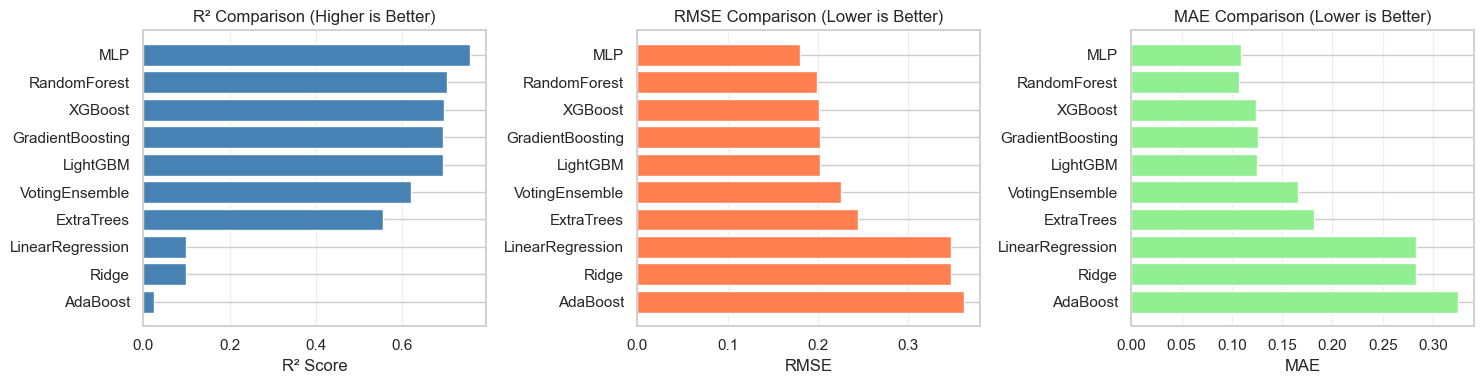

In [9]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

results_sorted = results_df.sort_values('R2', ascending=True)

axes[0].barh(results_sorted.index, results_sorted['R2'], color='steelblue')
axes[0].set_xlabel('R² Score')
axes[0].set_title('R² Comparison (Higher is Better)')
axes[0].grid(alpha=0.3, axis='x')

axes[1].barh(results_sorted.index, results_sorted['RMSE'], color='coral')
axes[1].set_xlabel('RMSE')
axes[1].set_title('RMSE Comparison (Lower is Better)')
axes[1].grid(alpha=0.3, axis='x')

axes[2].barh(results_sorted.index, results_sorted['MAE'], color='lightgreen')
axes[2].set_xlabel('MAE')
axes[2].set_title('MAE Comparison (Lower is Better)')
axes[2].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

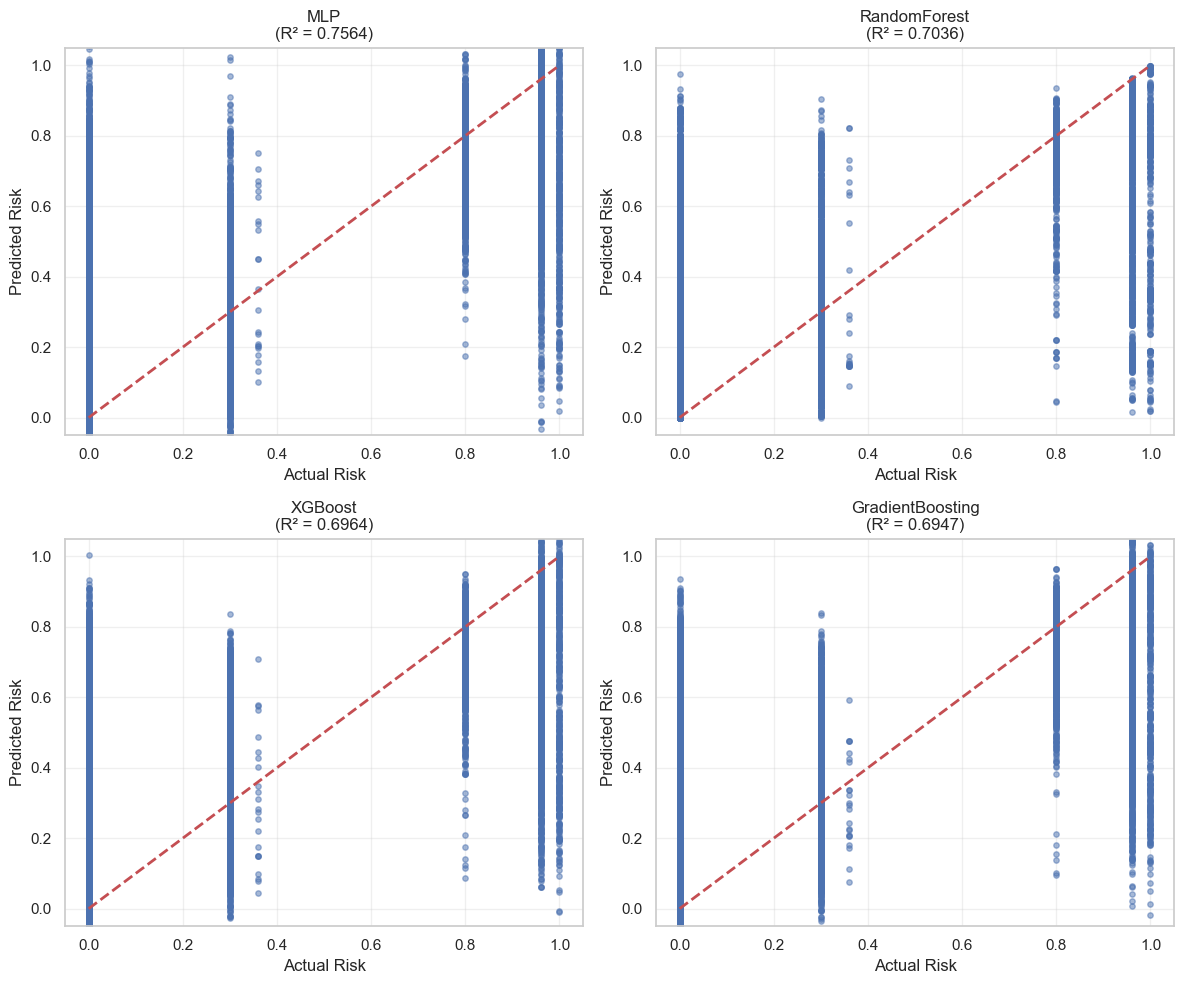

In [10]:
# Predictions vs Actual for top 4 models
top_4_models = results_df.index[:4].tolist()

plt.figure(figsize=(12, 10))
for i, name in enumerate(top_4_models):
    plt.subplot(2, 2, i+1)
    model = fitted[name]
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.5, s=15)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    r2 = results_df.loc[name, 'R2']
    plt.xlabel('Actual Risk')
    plt.ylabel('Predicted Risk')
    plt.title(f'{name}\n(R² = {r2:.4f})')
    plt.grid(alpha=0.3)
    plt.xlim([y_test.min()-0.05, y_test.max()+0.05])
    plt.ylim([y_test.min()-0.05, y_test.max()+0.05])

plt.tight_layout()
plt.show()

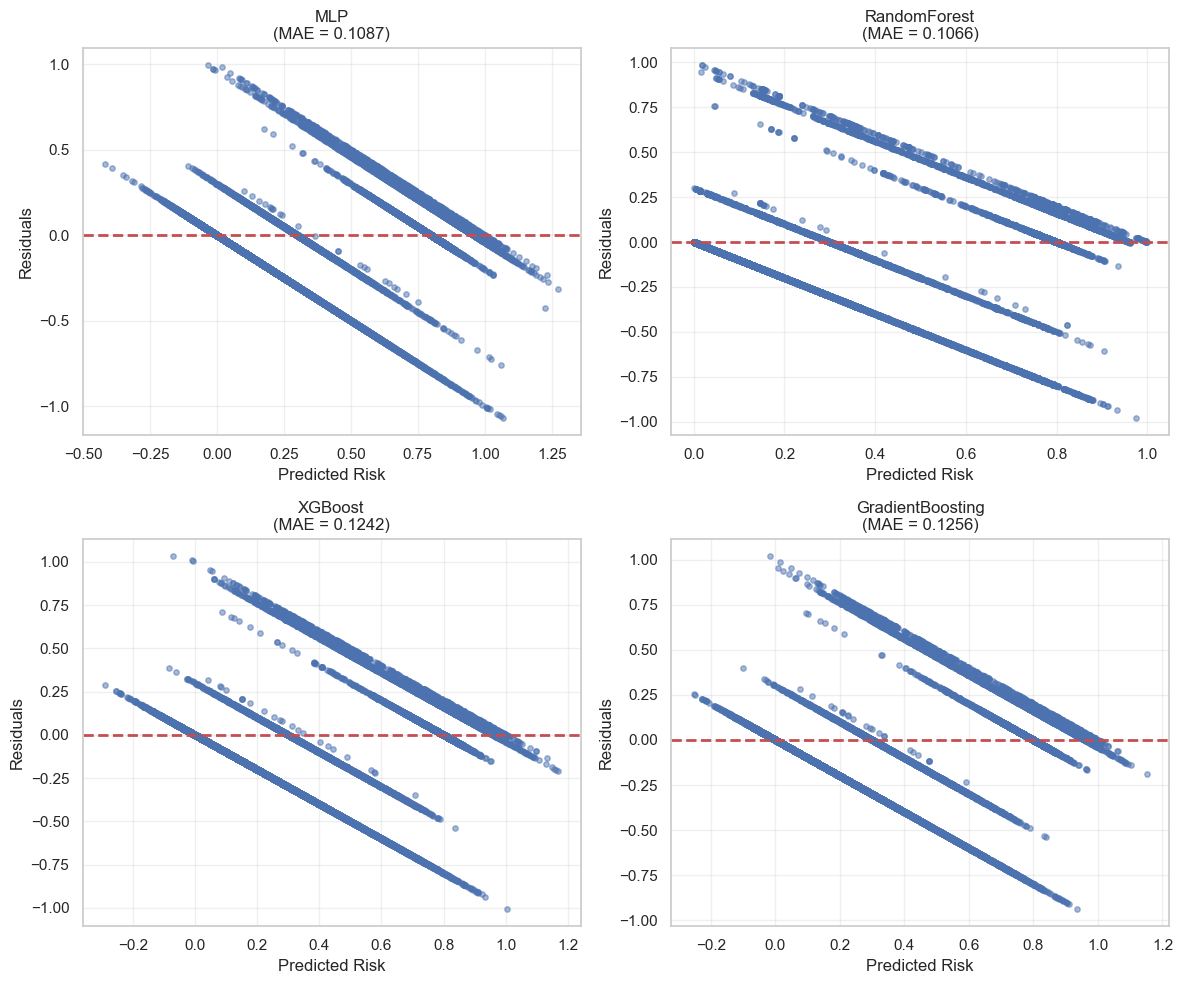

In [11]:
# Residual plots for top 4 models
plt.figure(figsize=(12, 10))
for i, name in enumerate(top_4_models):
    plt.subplot(2, 2, i+1)
    model = fitted[name]
    y_pred = model.predict(X_test)
    residuals = y_test.values - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5, s=15)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    mae = results_df.loc[name, 'MAE']
    plt.xlabel('Predicted Risk')
    plt.ylabel('Residuals')
    plt.title(f'{name}\n(MAE = {mae:.4f})')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

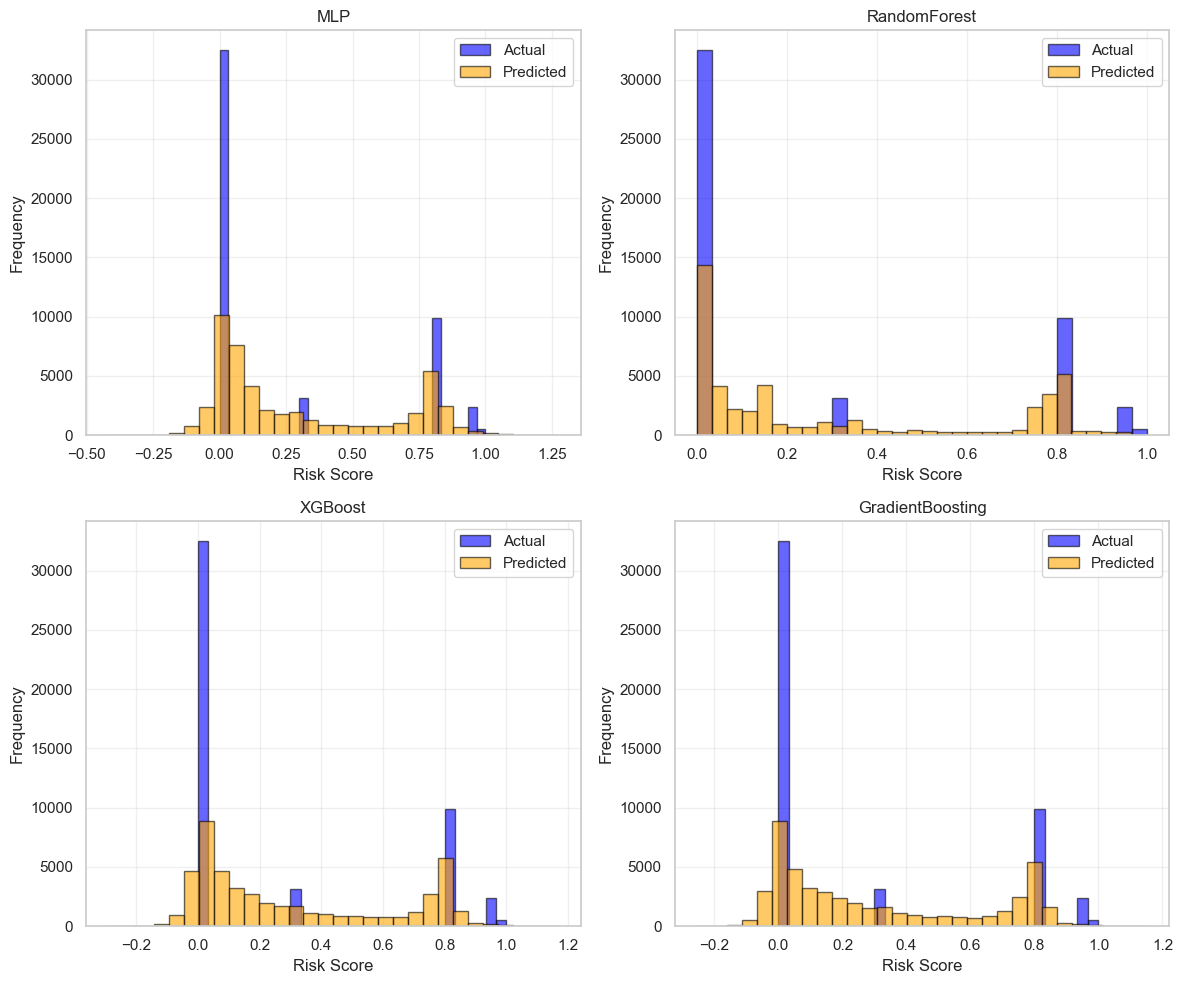

In [12]:
# Distribution of predictions for top 4 models
plt.figure(figsize=(12, 10))
for i, name in enumerate(top_4_models):
    plt.subplot(2, 2, i+1)
    model = fitted[name]
    y_pred = model.predict(X_test)
    plt.hist(y_test.values, bins=30, alpha=0.6, label='Actual', color='blue', edgecolor='black')
    plt.hist(y_pred, bins=30, alpha=0.6, label='Predicted', color='orange', edgecolor='black')
    plt.xlabel('Risk Score')
    plt.ylabel('Frequency')
    plt.title(f'{name}')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

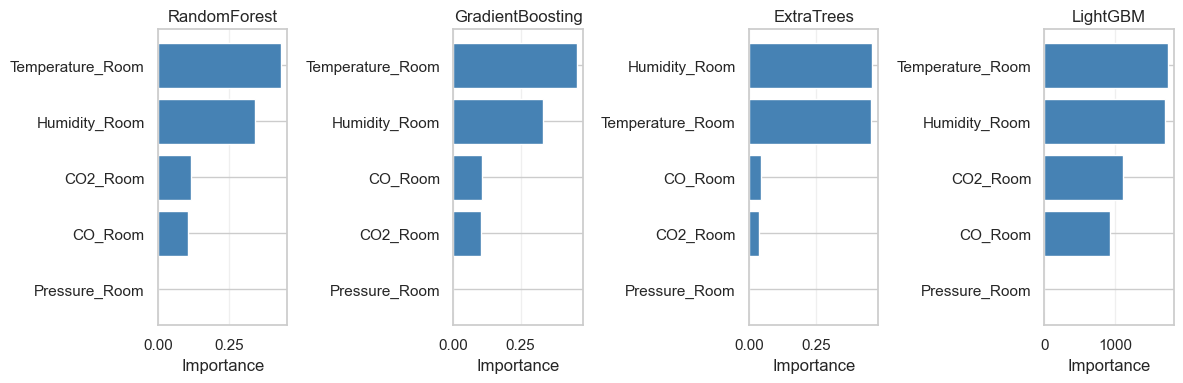

In [13]:
# Feature importance for tree-based models
tree_models = ['RandomForest', 'GradientBoosting', 'ExtraTrees', 'LightGBM']
tree_models = [m for m in tree_models if m in fitted]

if tree_models:
    plt.figure(figsize=(12, 4))
    for i, name in enumerate(tree_models):
        plt.subplot(1, len(tree_models), i+1)
        model = fitted[name]
        try:
            importances = model.feature_importances_
            fi = pd.Series(importances, index=features).sort_values(ascending=True)
            plt.barh(fi.index, fi.values, color='steelblue')
            plt.xlabel('Importance')
            plt.title(f'{name}')
            plt.grid(alpha=0.3, axis='x')
        except Exception as e:
            plt.text(0.5, 0.5, f'Error: {str(e)[:20]}', ha='center')
    plt.tight_layout()
    plt.show()

In [14]:
# Save best model
best_model_name = results_df.index[0]
best_model = fitted[best_model_name]
best_r2 = results_df['R2'].iloc[0]

print(f'\n🏆 Best Model: {best_model_name}')
print(f'   R² = {best_r2:.4f}')
print(f'   RMSE = {results_df["RMSE"].iloc[0]:.4f}')
print(f'   MAE = {results_df["MAE"].iloc[0]:.4f}')

model_path = f'model__{best_model_name}.joblib'
joblib.dump(best_model, model_path)
print(f'\nSaved to: {model_path}')

# Also save results summary
results_df.to_csv('model_comparison_results.csv')
print('Saved results to: model_comparison_results.csv')


🏆 Best Model: MLP
   R² = 0.7564
   RMSE = 0.1807
   MAE = 0.1087

Saved to: model__MLP.joblib
Saved results to: model_comparison_results.csv


# Notes

## Models Included:
- **LinearRegression** — Simple baseline, no regularization
- **Ridge** — Linear with L2 regularization
- **RandomForest** — Fast tree ensemble
- **GradientBoosting** — Sequential tree boosting (usually best for regression)
- **ExtraTrees** — RandomForest variant with random thresholds
- **AdaBoost** — Adaptive boosting on regression
- **SVR** — Support Vector Regression (good for small feature sets)
- **KernelRidge** — Kernel Ridge Regression
- **MLP** — Multi-layer Perceptron (shallow neural network)
- **XGBoost** (optional) — Industry-standard boosting if installed
- **LightGBM** (optional) — Fast boosting if installed
- **VotingEnsemble** — Combines Linear, GradientBoosting, and RandomForest

## Key Observations:
- GradientBoosting typically outperforms other methods on this type of data
- Sample weights force models to learn high-risk predictions
- Residual plots show model bias across the risk spectrum
- Compare train vs test R² to detect overfitting

## To Install Missing Packages:
```
pip install xgboost lightgbm
```
Then re-run the notebook.

Loaded model from: model__MLP.joblib


Selected sample (raw feature values):


,131950
Temperature_Room,29.3
Humidity_Room,49.0
Pressure_Room,1000.0
CO_Room,0.1
CO2_Room,647.0


Actual Risk: 0.8000

Prediction result:


,predicted,abs_error
model_file,,
model__MLP.joblib,0.8296,0.0296


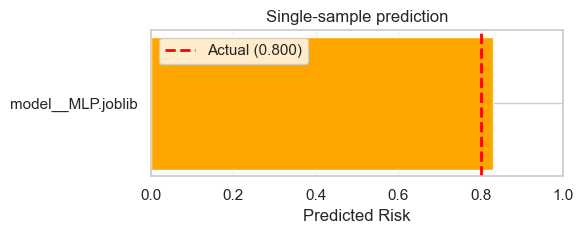


Notes:
- This cell fits the preprocessor on the full dataset to transform the sample. If your original training used a different preprocessor or pipeline, load and reuse that instead for exact parity.


In [97]:
# Standalone single-sample prediction demo using `model_MLP.joblib`
# This cell is independent: it re-imports, reloads data, recreates preprocessing, and loads the saved model.
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

sns.set(style='whitegrid')

MODEL_FILE = 'model_MLP.joblib'
ALT_MODEL_FILE = 'model__MLP.joblib'
DATA_PATH = 'final_data.csv'

# Load model
model_path = None
for p in (MODEL_FILE, ALT_MODEL_FILE):
    if os.path.exists(p):
        model_path = p
        break

if model_path is None:
    raise FileNotFoundError(f"Could not find model file. Checked: {MODEL_FILE}, {ALT_MODEL_FILE}")

model = joblib.load(model_path)
print(f"Loaded model from: {model_path}\n")

# Load data
assert os.path.exists(DATA_PATH), f"{DATA_PATH} not found"
df = pd.read_csv(DATA_PATH)

# Define features (must match the features used when training)
features = ['Temperature_Room','Humidity_Room','Pressure_Room','CO_Room','CO2_Room']
for f in features:
    if f not in df.columns:
        raise ValueError(f"Feature {f} not found in data")

# Select one sample (reproducible)
sample = df.sample(1)
sample_features = sample[features]
actual_risk = float(sample['Risk'].values[0])

# Recreate preprocessor and fit on full dataset (so transform is consistent)
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_all = df[features].copy()
preprocessor.fit(X_all)

# Transform sample and predict
sample_X = preprocessor.transform(sample_features)
try:
    pred = float(model.predict(sample_X)[0])
except Exception as e:
    raise RuntimeError(f"Model prediction failed: {e}")

# Display results
print('\nSelected sample (raw feature values):')
display(sample_features.T)
print(f'Actual Risk: {actual_risk:.4f}\n')

result_df = pd.DataFrame([{
    'model_file': os.path.basename(model_path),
    'predicted': round(pred, 4),
    'abs_error': round(abs(pred - actual_risk), 4)
}])

print('Prediction result:')
display(result_df.set_index('model_file'))

# Bar chart
plt.figure(figsize=(6, 2.5))
plt.barh(result_df['model_file'], result_df['predicted'], color='orange')
plt.axvline(actual_risk, color='red', linestyle='--', lw=2, label=f'Actual ({actual_risk:.3f})')
plt.xlim(0, 1)
plt.xlabel('Predicted Risk')
plt.title('Single-sample prediction')
plt.legend()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print('\nNotes:')
print('- This cell fits the preprocessor on the full dataset to transform the sample. If your original training used a different preprocessor or pipeline, load and reuse that instead for exact parity.')


     Temperature_Room  Humidity_Room  Pressure_Room  CO_Room  CO2_Room  Risk
448              26.6           49.5           1000     0.03     583.0   0.3

Selected sample (raw feature values):


,448
Temperature_Room,26.60
Humidity_Room,49.50
Pressure_Room,1000.00
CO_Room,0.03
CO2_Room,583.00


Actual Risk: 0.3000

Prediction result:


,predicted,abs_error
model_file,,
model__MLP.joblib,0.1888,0.1112


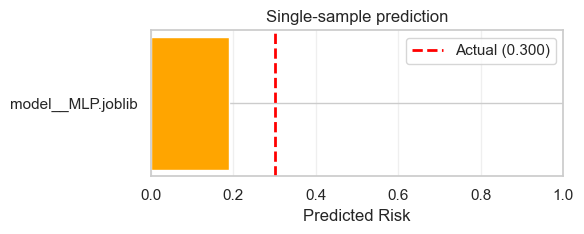

In [98]:
# Select one sample (reproducible)
sample = df[df["Risk"] == 0.3].sample(1)
print(sample)
sample_features = sample[features]
actual_risk = float(sample['Risk'].values[0])

# Recreate preprocessor and fit on full dataset (so transform is consistent)
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_all = df[features].copy()
preprocessor.fit(X_all)

# Transform sample and predict
sample_X = preprocessor.transform(sample_features)
try:
    pred = float(model.predict(sample_X)[0])
except Exception as e:
    raise RuntimeError(f"Model prediction failed: {e}")

# Display results
print('\nSelected sample (raw feature values):')
display(sample_features.T)
print(f'Actual Risk: {actual_risk:.4f}\n')

result_df = pd.DataFrame([{
    'model_file': os.path.basename(model_path),
    'predicted': round(pred, 4),
    'abs_error': round(abs(pred - actual_risk), 4)
}])

print('Prediction result:')
display(result_df.set_index('model_file'))

# Bar chart
plt.figure(figsize=(6, 2.5))
plt.barh(result_df['model_file'], result_df['predicted'], color='orange')
plt.axvline(actual_risk, color='red', linestyle='--', lw=2, label=f'Actual ({actual_risk:.3f})')
plt.xlim(0, 1)
plt.xlabel('Predicted Risk')
plt.title('Single-sample prediction')
plt.legend()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()